# Modelling

In [1]:
#!pip install imbalanced-learn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
                             accuracy_score, plot_roc_curve, roc_auc_score,
                             recall_score, precision_score, f1_score)

In [3]:
songs = pd.read_csv('data/songs_clean.csv')

In [4]:
songs.columns

Index(['artist', 'album', 'release_date', 'track_name', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'hit', 'duration', 'release_day', 'release_month', 'release_year'],
      dtype='object')

In [5]:
songs['release_date'] = pd.to_datetime(songs['release_date'])

In [7]:
songs['hit'].value_counts(normalize=True)

0    0.924129
1    0.075871
Name: hit, dtype: float64

From the initial data pull, the classes are extremely unbalanced. In order to address the imbalanced classes, I defined a SMOTE instance that will balance the minority class.

In [9]:
#removed energy
features = ['release_year','release_day','release_month','danceability', 'key', 'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration', 'time_signature']

In [10]:
X = songs[features]
y = songs['hit']

# transform the dataset
sm = SMOTE(random_state=77)
X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 77)

sc = StandardScaler()
sc.fit(X_train) # Learns the means and standard deviations for each columns

#Using the fit StandardScaler - transform the data
Z_train = sc.transform(X_train)
Z_test = sc.transform(X_test)

In [12]:
y_test.value_counts(normalize=True)

1    0.500086
0    0.499914
Name: hit, dtype: float64

## Logistic Regression

In [13]:
#lr = LogisticRegression(penalty='l1',solver='liblinear')
lr = LogisticRegression()
lr.fit(Z_train,y_train)

print(lr.score(Z_train, y_train))
#Accuracy Score 
print(lr.score(Z_test, y_test)) #This is showing that with the model is correct 83% of the time

0.7518102514396487
0.7600478878057123


In [15]:
lr_preds = lr.predict(Z_test)

In [16]:
confusion_matrix(y_test,lr_preds)

array([[2016,  907],
       [ 496, 2428]], dtype=int64)

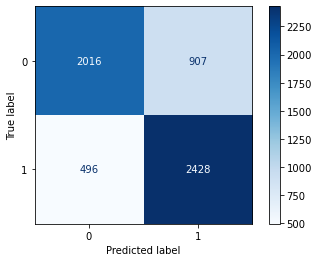

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_preds).ravel()
plot_confusion_matrix(lr, Z_test, y_test, cmap='Blues', values_format='d');

In [18]:
recall_score(y_test, lr_preds)

0.8303693570451436

In [19]:
precision_score(y_test, lr_preds)

0.7280359820089956

In [61]:
f1_score(y_test,lr_preds)

0.775842786387602

## KNN Model

In [21]:
knn = KNeighborsClassifier()

knn.fit(Z_train,y_train)
print(knn.score(Z_train,y_train))
print(knn.score(Z_test,y_test))

0.8716004333200297
0.8315375406191209


In [22]:
knn_preds = knn.predict(Z_test)

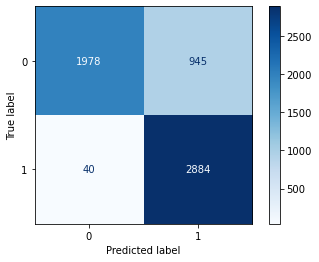

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, knn_preds).ravel()
plot_confusion_matrix(knn, Z_test, y_test, cmap='Blues', values_format='d');

In [24]:
# Calculate the specificity
recall_score(y_test, knn_preds)

0.9863201094391245

In [25]:
precision_score(y_test, knn_preds)

0.753199268738574

In [62]:
f1_score(y_test,knn_preds)

0.8541389012290833

# Random Forest

In [26]:
rf = RandomForestClassifier(random_state=50, n_jobs=4)

rf_params = {
    'n_estimators': [200,250,300,350],
    'max_features': ['auto'],
    'max_depth': [5,6,7],
    'min_samples_leaf': [1,2,3,4],
    'ccp_alpha': [0.0001, 0.001,0.01,0]
}

rf_gs = GridSearchCV(rf, 
                  param_grid=rf_params, 
                  cv=5,
                 verbose=1,
                 n_jobs=6)

rf_gs.fit(Z_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4, random_state=50),
             n_jobs=6,
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01, 0],
                         'max_depth': [5, 6, 7], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [200, 250, 300, 350]},
             verbose=1)

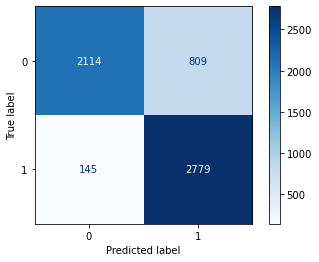

In [49]:
rf_preds = rf_gs.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()
plot_confusion_matrix(rf_gs, Z_test, y_test, cmap='Blues', values_format='d');

In [50]:
print(rf_gs.score(Z_train, y_train))
print(rf_gs.score(Z_test, y_test))

0.8513028108786134
0.8368394048229861


In [51]:
# Calculate the specificity
recall_score(y_test, rf_preds)

0.9504103967168263

In [52]:
precision_score(y_test, rf_preds)

0.7745261984392419

In [63]:
f1_score(y_test,rf_preds)

0.8535012285012286

## Voting Tree Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)

knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('knn_pipe', knn_pipe)
])
#saying cycle through the ada base estimator of decisiontreeclassifier with default max depth 1 and specified max depth 2
#we refer to the alias estimator first then doubleunderscore then the hyperparameters we want to optimize
vote_params = {
    'ada__base_estimator': [None, DecisionTreeClassifier(max_depth=2)], 
    'ada__n_estimators': [50,75], 
    'gb__n_estimators': [100,125],
    'tree__max_depth': [None, 5],
    'knn_pipe__knn__n_neighbors':[3,4,5] #the two double underscore refers to the knn_pipe alias and the knn alias parameters
}

gs = GridSearchCV(vote, param_grid=vote_params, cv=3, n_jobs=6)
gs.fit(Z_train, y_train)
gs.best_params_

{'ada__base_estimator': DecisionTreeClassifier(max_depth=2),
 'ada__n_estimators': 75,
 'gb__n_estimators': 125,
 'knn_pipe__knn__n_neighbors': 3,
 'tree__max_depth': None}

In [53]:
print(gs.score(Z_train,y_train))
print(gs.score(Z_test,y_test))

0.9463481384343463
0.8943047716777834


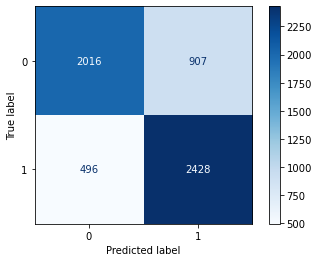

In [54]:
gs_preds = gs.predict(Z_test)
tn, fp, fn, tp = confusion_matrix(y_test, gs_preds).ravel()
plot_confusion_matrix(lr, Z_test, y_test, cmap='Blues', values_format='d');

In [55]:
recall_score(y_test, gs_preds)

0.9357045143638851

In [56]:
precision_score(y_test, gs_preds)

0.8641819330385344

In [64]:
f1_score(y_test,gs_preds)

0.8985221674876848

# SVM - blackbox method

In [36]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [37]:
# Instantiate SVM.
svc = SVC()

svc.fit(Z_train,y_train)

print(svc.score(Z_train,y_train))
print(svc.score(Z_test,y_test))

0.862078795826444
0.8530870531896699


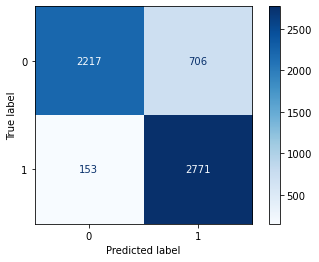

In [57]:
svc_preds = svc.predict(Z_test)
tn, fp, fn, tp = confusion_matrix(y_test, svc_preds).ravel()
plot_confusion_matrix(svc, Z_test, y_test, cmap='Blues', values_format='d');

In [39]:
recall_score(y_test, svc_preds)

0.9476744186046512

In [40]:
precision_score(y_test, svc_preds)

0.7969513948806443

In [65]:
f1_score(y_test,svc_preds)

0.8658022184033746

## Neural Network

In [41]:
Z_train[0].shape

(14,)

In [42]:
nn = Sequential()

nn.add(Dense(16, input_shape=Z_train[0].shape, activation='relu')) 
nn.add(Dense(16, activation='relu')) 
nn.add(Dense(1, activation='sigmoid')) 
early_stop= EarlyStopping(patience=5, restore_best_weights=True)
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [43]:
nn.compile(loss='bce', optimizer='adam', metrics=['acc'])

results = nn.fit(Z_train, y_train, 
                epochs=200, 
                validation_data=(Z_test, y_test),
                verbose=0, 
                batch_size=512,
                callbacks=[early_stop]) 

results.history['acc'][-1], results.history['val_acc'][-1]

(0.86356121301651, 0.8558235168457031)

In [44]:
# nn_preds must be rounded
nn_preds = nn.predict(Z_test)
nn_preds_rounded = np.round(nn_preds)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, nn_preds_rounded).ravel()

In [46]:
sens = tp / (tp + fn)
sens

0.9158686730506156

In [47]:
prec = tp/(tp + fp)
prec

0.8222290451335585

In [48]:
spec = tn / (tp + fn)
spec

0.801641586867305

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [67]:
(2 * sens * prec) / (prec + sens)

0.8665264520304159